# Imports

In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import gc, joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## import data

In [2]:
def import_data(seq_length):
    matrix_array = np.load(f'Data/matrix_array_{seq_length}_normalized.npy')
    answer_array = np.load(f'Data/answer_array_{seq_length}.npy')

    X = matrix_array
    y = answer_array

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=1, stratify=y)

    X_test_flattened = np.array([x.flatten() for x in X_test])

    y_test_transformed = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else -1) for y in y_test])
    # answer = chunk.iloc[i+19][['plus_6', 'minus_6', 'zero_6']].tolist()
    # zero = 0, up = 1, down = -1
    y_test_transformed012 = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else 2) for y in y_test])
    # 1 = up , 2 = down, 0 = zero

    del X, y, X_train, X_test, y_train, y_test, matrix_array, answer_array
    gc.collect()

    return X_test_flattened, y_test_transformed, y_test_transformed012


## test models

In [3]:
def test_model(model_name, seq_length):
    X_test_flattened, y_test_transformed, y_test_transformed012 = import_data(seq_length)
    print(f'import {seq_length} Data Done')

    if model_name == 'XGB':
        y_test_transformed = y_test_transformed012
        
    model = joblib.load(f'Models/{model_name}_model_{seq_length}.pkl')
    print(f'import {model_name} model Done')

    y_pred = model.predict(X_test_flattened)
    print('prediction Done')

    print(np.unique(y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test_transformed, y_pred)
    print(f"Accuracy: {accuracy}")

    # Print classification report
    report = classification_report(y_test_transformed, y_pred)
    print("Classification Report:")
    print(report)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_transformed, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'{model_name}_{seq_length} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'Figures/{model_name}_{seq_length}_Counfusion_Matrix.png')
    plt.show()

    # accuracy?
    wrong_count = cm[0][1]+cm[0][2] + cm[1][0]+cm[1][2] + cm[2][0]+cm[2][1]
    correct_count = cm[0][0] + cm[1][1] + cm[2][2]

    print(f'wrong count : {wrong_count}, correct count : {correct_count}')
    print(f'accuracy? : {100*correct_count/(wrong_count+correct_count)}') 

    data = pd.read_csv('Data/df_all.csv')
    data = data.drop(['Open time', 'Close time', 'Ignore','up_cross','down_cross','minutes','log_minutes','side','plus_6','minus_6','zero_6'], axis=1)
    print(data.columns)

    # Rename columns
    new_columns = []
    for i in range(seq_length):  # for each time step
        new_columns.extend([f"{col}_{i}" for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume','MA5','MA10','MA20','MA30','MA60','MA120','MA240', 'BB0','BB+','BB-' ]])

    # Get feature importances
    importances = model.feature_importances_
    # Convert to a DataFrame
    feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    feature_importance_df.plot(kind='bar', x='Feature', y='Importance')
    plt.title('Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Display the top N features in a bar chart
    top_n = 20  # You can adjust this number
    top_features = feature_importance_df.head(top_n)
    top_features.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
    plt.title('Top Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Print the sorted list of features and their importances
    print("Sorted Feature Importances:")
    print(feature_importance_df.to_string(index=False))

    # Assuming importances and new_columns are defined
    feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

    # Split the feature names and aggregate importances
    feature_importance_df['BaseFeature'] = feature_importance_df['Feature'].apply(lambda x: x.split('_')[0])
    aggregated_importances = feature_importance_df.groupby('BaseFeature')['Importance'].sum()

    # Sort by importance
    aggregated_importances = aggregated_importances.sort_values(ascending=False)

    # Plot aggregated feature importances
    aggregated_importances.head(20).plot(kind='bar', figsize=(10, 6))
    plt.title('Aggregated Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Print the sorted list of aggregated features and their importances
    print("Sorted Aggregated Feature Importances:")
    print(aggregated_importances.to_string())


## predictions

import 20 Data Done
import RFC model Done


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


prediction Done
[-1  0  1]
Accuracy: 0.7212189033313248
Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.69      0.70     19417
           0       0.72      0.85      0.78     20466
           1       0.73      0.61      0.67     18202

    accuracy                           0.72     58085
   macro avg       0.72      0.72      0.72     58085
weighted avg       0.72      0.72      0.72     58085



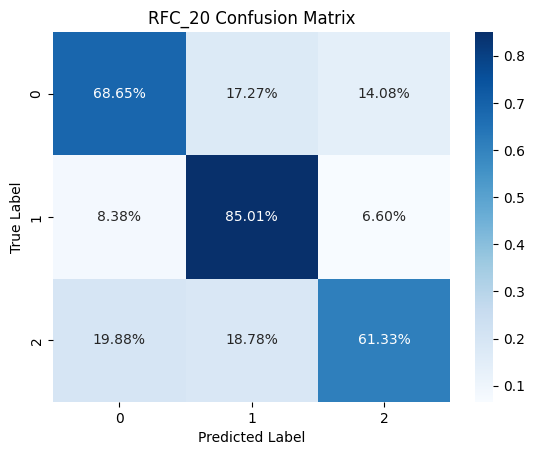

wrong count : 16193, correct count : 41892
accuracy? : 72.12189033313248
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


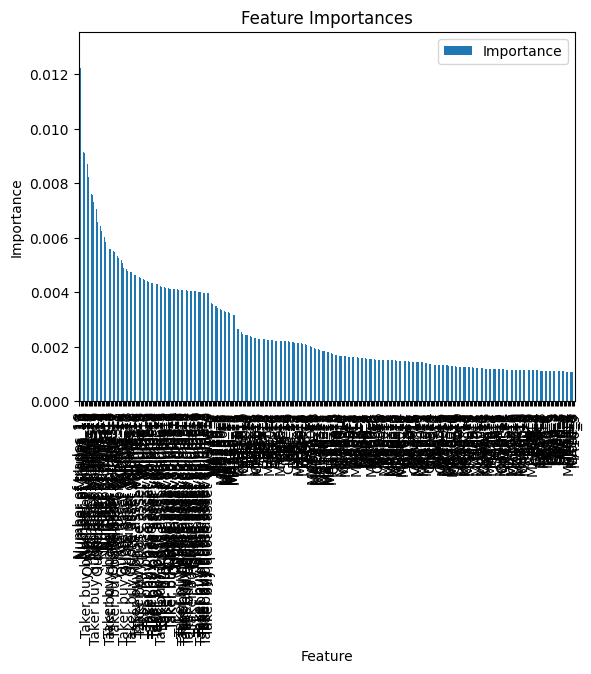

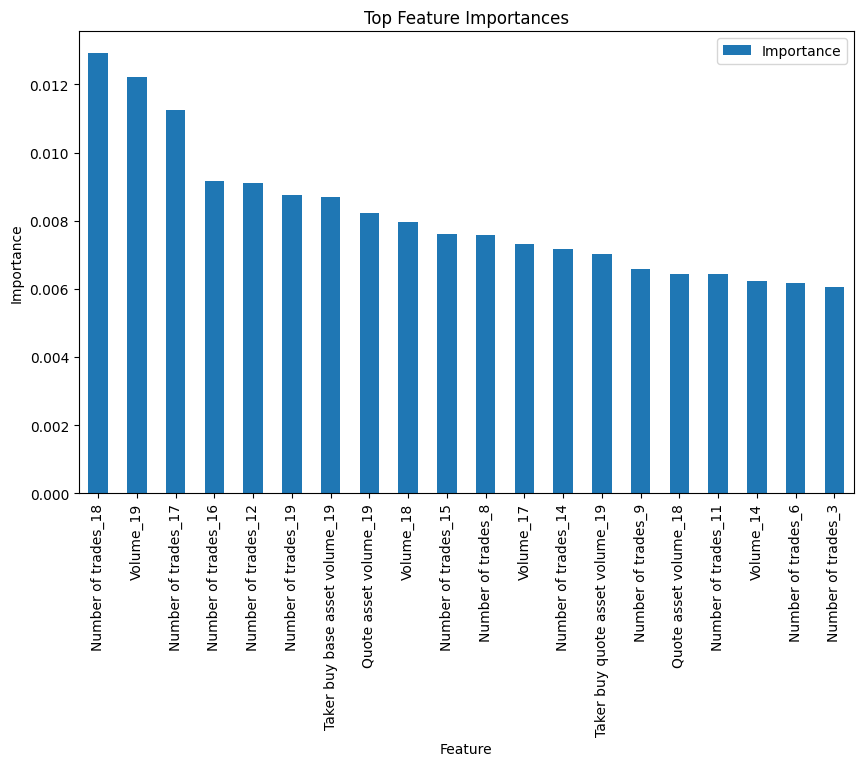

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_18    0.012905
                      Volume_19    0.012209
            Number of trades_17    0.011251
            Number of trades_16    0.009152
            Number of trades_12    0.009097
            Number of trades_19    0.008745
 Taker buy base asset volume_19    0.008691
          Quote asset volume_19    0.008213
                      Volume_18    0.007968
            Number of trades_15    0.007615
             Number of trades_8    0.007570
                      Volume_17    0.007307
            Number of trades_14    0.007163
Taker buy quote asset volume_19    0.007038
             Number of trades_9    0.006590
          Quote asset volume_18    0.006448
            Number of trades_11    0.006432
                      Volume_14    0.006241
             Number of trades_6    0.006183
             Number of trades_3    0.006044
            Number of trades_13    0.005836
    

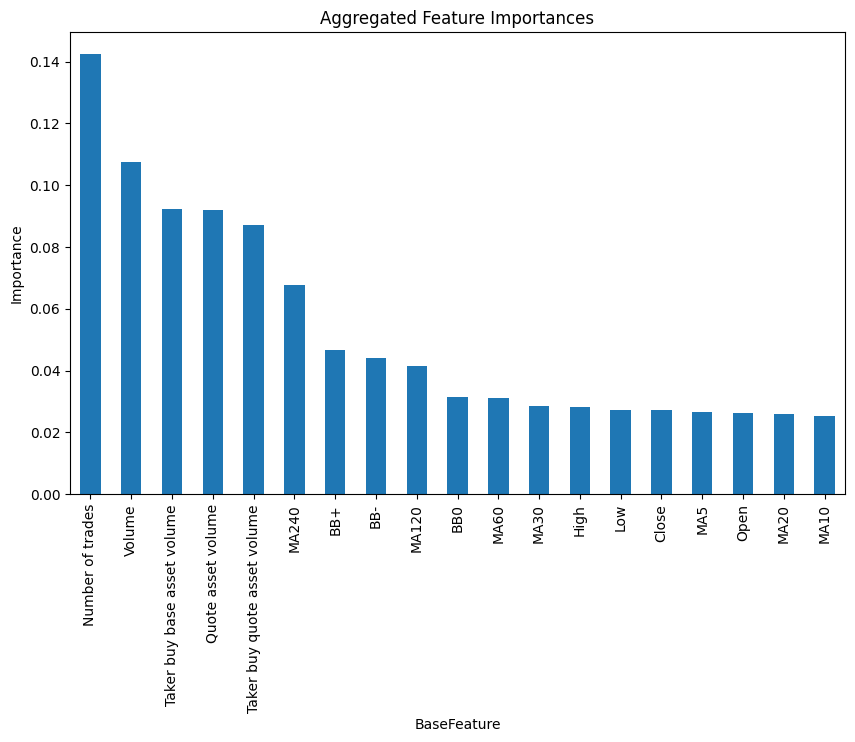

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.142399
Volume                          0.107490
Taker buy base asset volume     0.092404
Quote asset volume              0.091916
Taker buy quote asset volume    0.087244
MA240                           0.067620
BB+                             0.046831
BB-                             0.044246
MA120                           0.041581
BB0                             0.031560
MA60                            0.031026
MA30                            0.028536
High                            0.028312
Low                             0.027321
Close                           0.027151
MA5                             0.026656
Open                            0.026388
MA20                            0.025965
MA10                            0.025354
import 20 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5802702935353361
Classification Report:
              precision    recall  f1-score   suppor

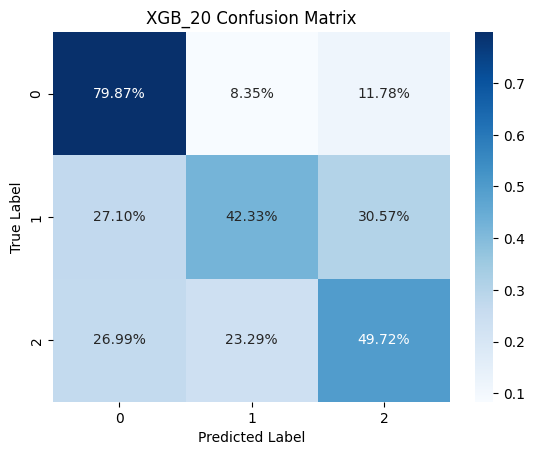

wrong count : 24380, correct count : 33705
accuracy? : 58.027029353533614
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


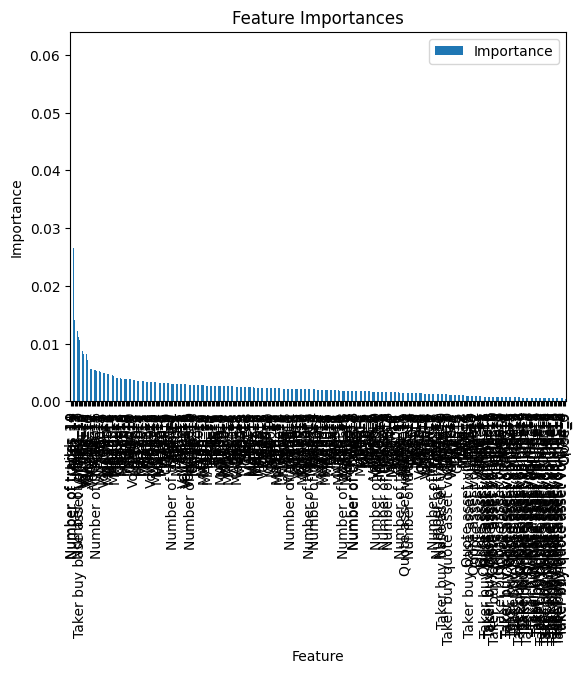

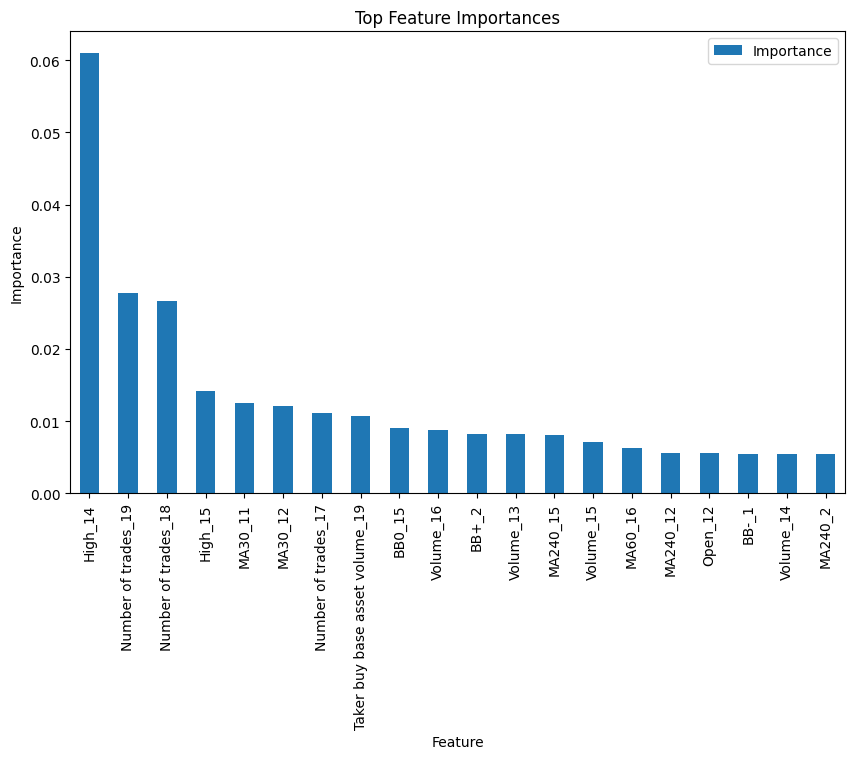

Sorted Feature Importances:
                        Feature  Importance
                        High_14    0.060935
            Number of trades_19    0.027782
            Number of trades_18    0.026646
                        High_15    0.014174
                        MA30_11    0.012473
                        MA30_12    0.012169
            Number of trades_17    0.011112
 Taker buy base asset volume_19    0.010671
                         BB0_15    0.009084
                      Volume_16    0.008749
                          BB+_2    0.008223
                      Volume_13    0.008181
                       MA240_15    0.008137
                      Volume_15    0.007096
                        MA60_16    0.006261
                       MA240_12    0.005618
                        Open_12    0.005573
                          BB-_1    0.005535
                      Volume_14    0.005440
                        MA240_2    0.005403
            Number of trades_16    0.005360
    

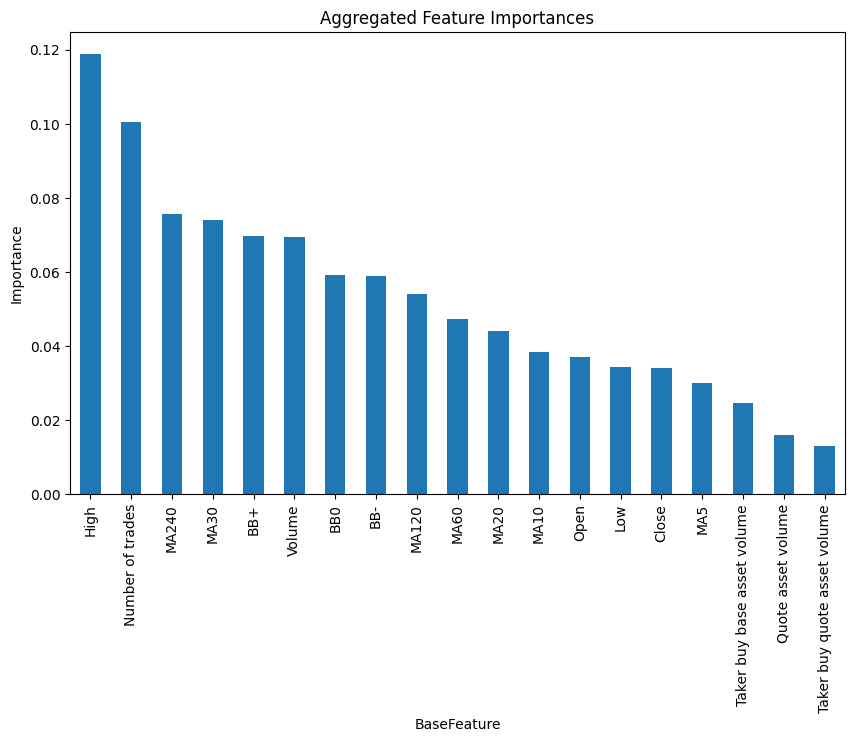

Sorted Aggregated Feature Importances:
BaseFeature
High                            0.118822
Number of trades                0.100605
MA240                           0.075719
MA30                            0.073920
BB+                             0.069809
Volume                          0.069566
BB0                             0.059104
BB-                             0.058831
MA120                           0.054129
MA60                            0.047441
MA20                            0.044154
MA10                            0.038427
Open                            0.037143
Low                             0.034412
Close                           0.034178
MA5                             0.029966
Taker buy base asset volume     0.024695
Quote asset volume              0.016008
Taker buy quote asset volume    0.013069
import 40 Data Done
import RFC model Done


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


prediction Done
[-1  0  1]
Accuracy: 0.7163425933899386
Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.68      0.69     19408
           0       0.71      0.85      0.77     20464
           1       0.73      0.61      0.67     18191

    accuracy                           0.72     58063
   macro avg       0.72      0.71      0.71     58063
weighted avg       0.72      0.72      0.71     58063



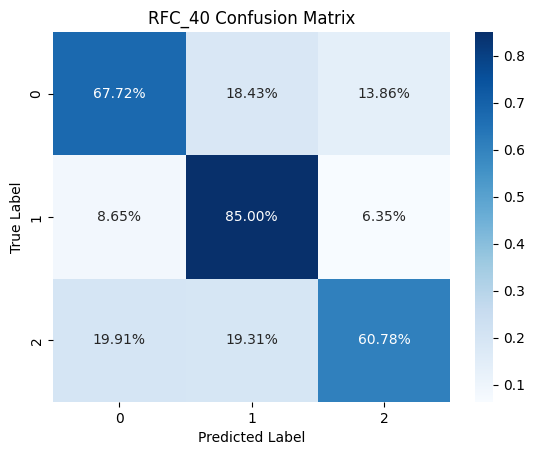

wrong count : 16470, correct count : 41593
accuracy? : 71.63425933899386
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


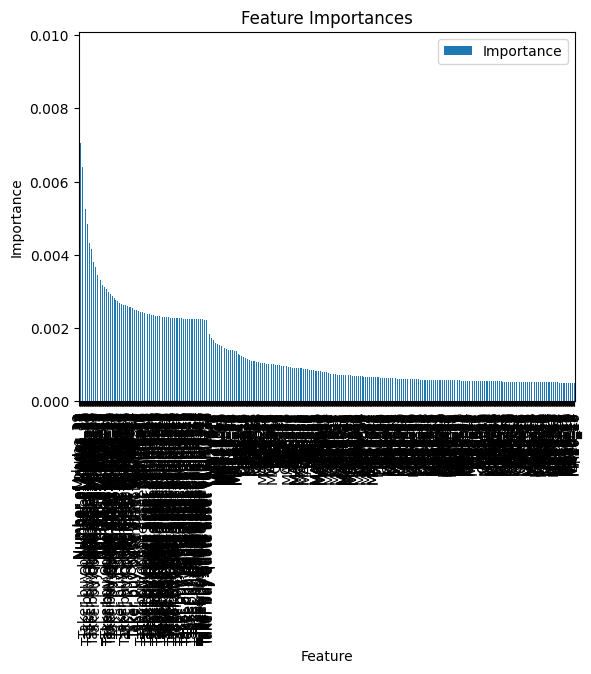

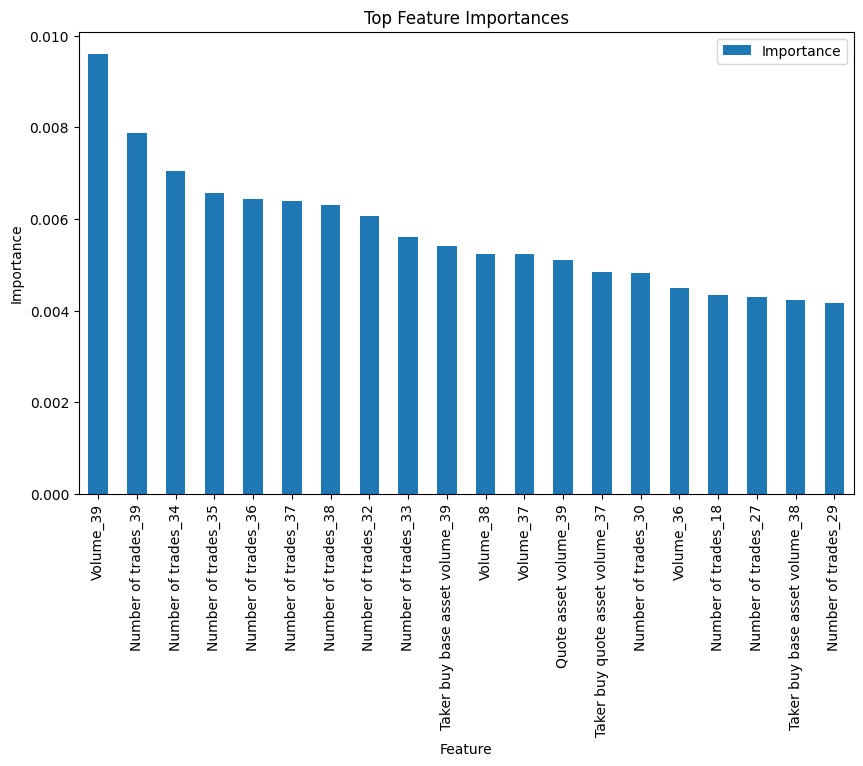

Sorted Feature Importances:
                        Feature  Importance
                      Volume_39    0.009607
            Number of trades_39    0.007870
            Number of trades_34    0.007046
            Number of trades_35    0.006564
            Number of trades_36    0.006425
            Number of trades_37    0.006391
            Number of trades_38    0.006294
            Number of trades_32    0.006073
            Number of trades_33    0.005604
 Taker buy base asset volume_39    0.005405
                      Volume_38    0.005242
                      Volume_37    0.005232
          Quote asset volume_39    0.005101
Taker buy quote asset volume_37    0.004847
            Number of trades_30    0.004815
                      Volume_36    0.004499
            Number of trades_18    0.004329
            Number of trades_27    0.004297
 Taker buy base asset volume_38    0.004223
            Number of trades_29    0.004174
          Quote asset volume_38    0.004044
    

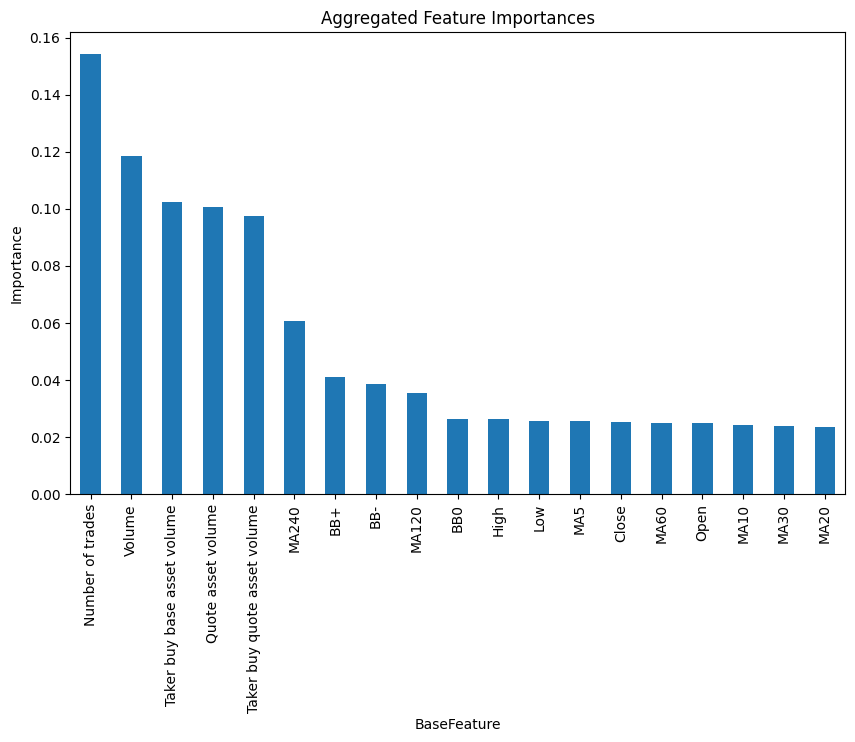

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.154151
Volume                          0.118516
Taker buy base asset volume     0.102549
Quote asset volume              0.100550
Taker buy quote asset volume    0.097346
MA240                           0.060655
BB+                             0.040969
BB-                             0.038480
MA120                           0.035573
BB0                             0.026494
High                            0.026270
Low                             0.025773
MA5                             0.025491
Close                           0.025473
MA60                            0.025116
Open                            0.024881
MA10                            0.024376
MA30                            0.023903
MA20                            0.023433
import 40 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5881886915936139
Classification Report:
              precision    recall  f1-score   suppor

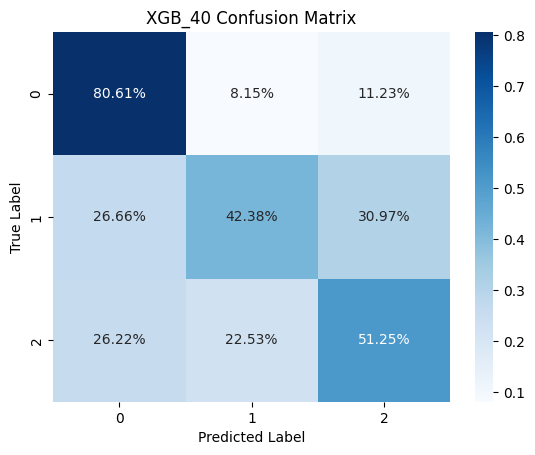

wrong count : 23911, correct count : 34152
accuracy? : 58.818869159361384
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


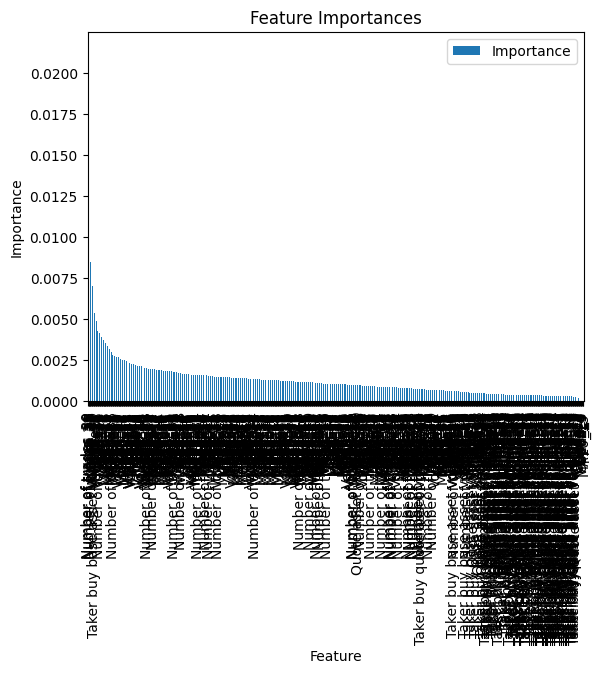

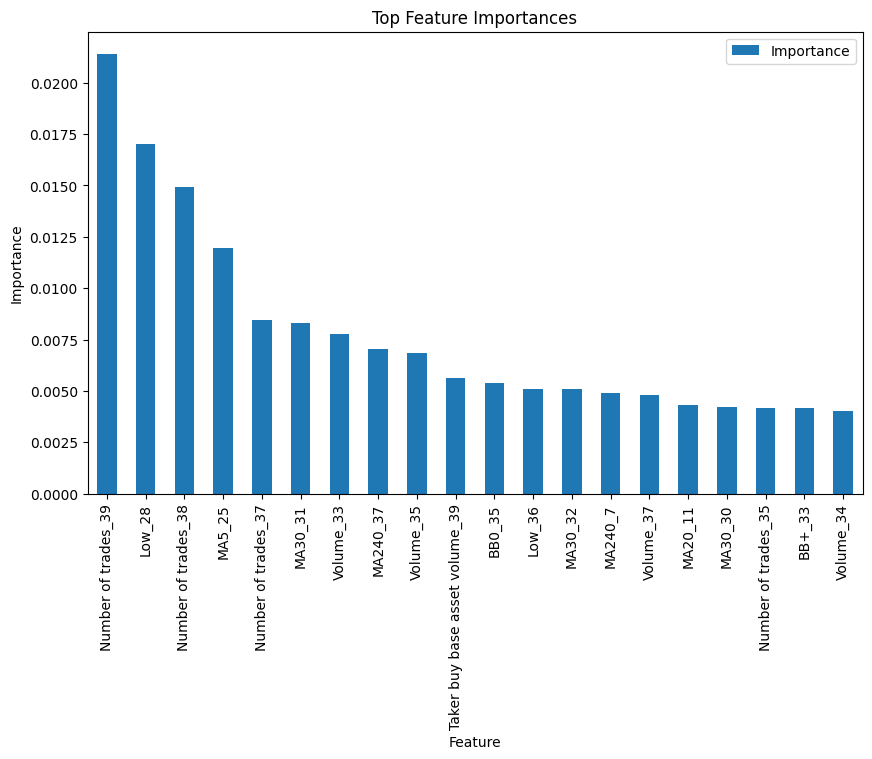

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_39    0.021420
                         Low_28    0.017016
            Number of trades_38    0.014944
                         MA5_25    0.011960
            Number of trades_37    0.008464
                        MA30_31    0.008304
                      Volume_33    0.007788
                       MA240_37    0.007022
                      Volume_35    0.006828
 Taker buy base asset volume_39    0.005607
                         BB0_35    0.005364
                         Low_36    0.005113
                        MA30_32    0.005076
                        MA240_7    0.004920
                      Volume_37    0.004780
                        MA20_11    0.004313
                        MA30_30    0.004204
            Number of trades_35    0.004170
                         BB+_33    0.004153
                      Volume_34    0.004037
                          MA5_9    0.004010
    

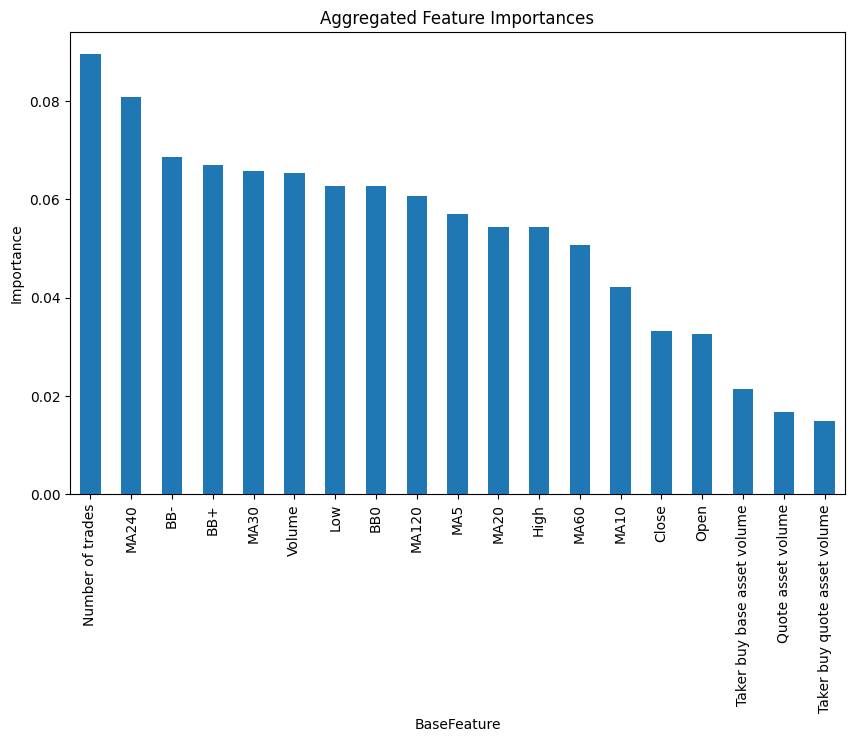

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.089504
MA240                           0.080761
BB-                             0.068549
BB+                             0.066918
MA30                            0.065683
Volume                          0.065374
Low                             0.062781
BB0                             0.062778
MA120                           0.060721
MA5                             0.056909
MA20                            0.054264
High                            0.054258
MA60                            0.050638
MA10                            0.042090
Close                           0.033141
Open                            0.032634
Taker buy base asset volume     0.021415
Quote asset volume              0.016649
Taker buy quote asset volume    0.014932
import 60 Data Done
import RFC model Done


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


prediction Done
[-1  0  1]
Accuracy: 0.7152530108027084
Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.67      0.69     19402
           0       0.71      0.85      0.77     20463
           1       0.74      0.61      0.67     18176

    accuracy                           0.72     58041
   macro avg       0.72      0.71      0.71     58041
weighted avg       0.72      0.72      0.71     58041



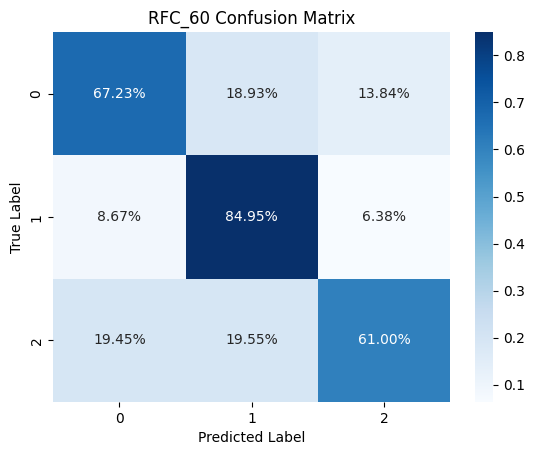

wrong count : 16527, correct count : 41514
accuracy? : 71.52530108027084
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


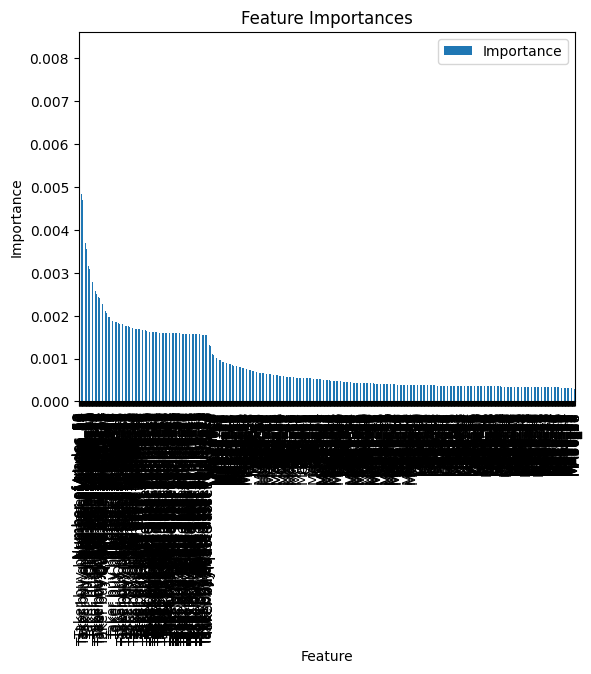

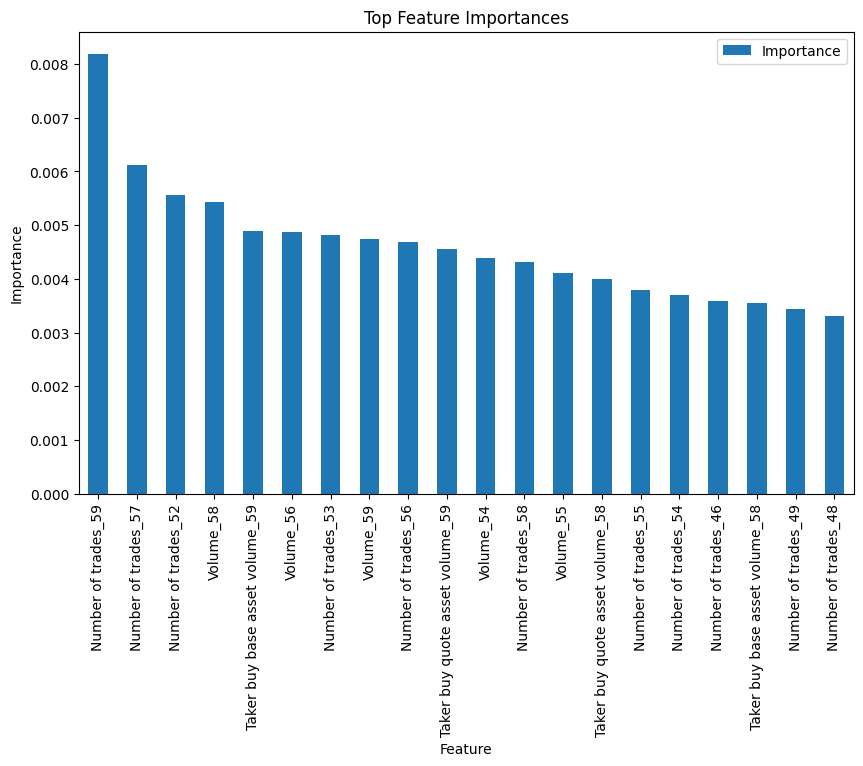

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_59    0.008195
            Number of trades_57    0.006112
            Number of trades_52    0.005556
                      Volume_58    0.005431
 Taker buy base asset volume_59    0.004899
                      Volume_56    0.004880
            Number of trades_53    0.004825
                      Volume_59    0.004750
            Number of trades_56    0.004685
Taker buy quote asset volume_59    0.004555
                      Volume_54    0.004393
            Number of trades_58    0.004316
                      Volume_55    0.004114
Taker buy quote asset volume_58    0.003988
            Number of trades_55    0.003793
            Number of trades_54    0.003697
            Number of trades_46    0.003589
 Taker buy base asset volume_58    0.003546
            Number of trades_49    0.003447
            Number of trades_48    0.003302
            Number of trades_50    0.003294
    

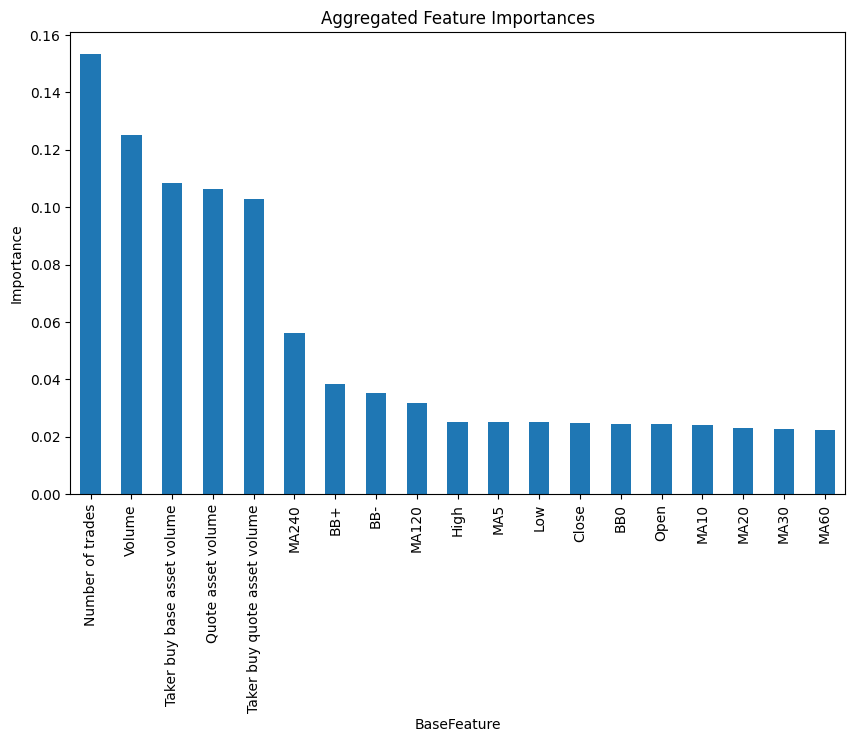

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.153320
Volume                          0.125252
Taker buy base asset volume     0.108546
Quote asset volume              0.106406
Taker buy quote asset volume    0.102993
MA240                           0.056118
BB+                             0.038446
BB-                             0.035211
MA120                           0.031741
High                            0.025213
MA5                             0.025212
Low                             0.025180
Close                           0.024944
BB0                             0.024525
Open                            0.024371
MA10                            0.024173
MA20                            0.023227
MA30                            0.022624
MA60                            0.022497
import 60 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5843110904360711
Classification Report:
              precision    recall  f1-score   suppor

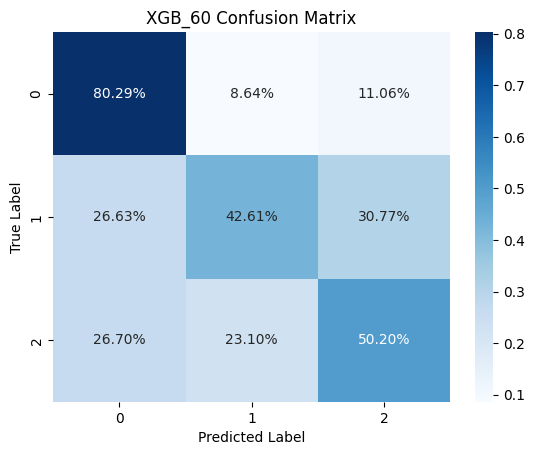

wrong count : 24127, correct count : 33914
accuracy? : 58.43110904360711
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


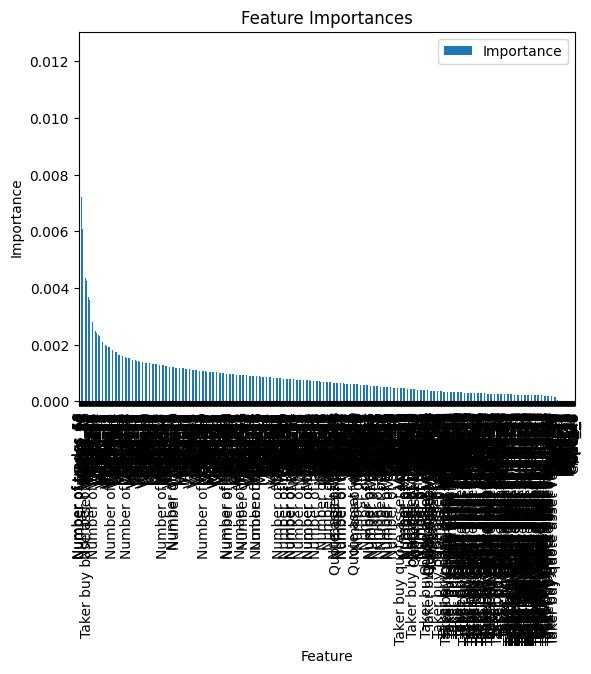

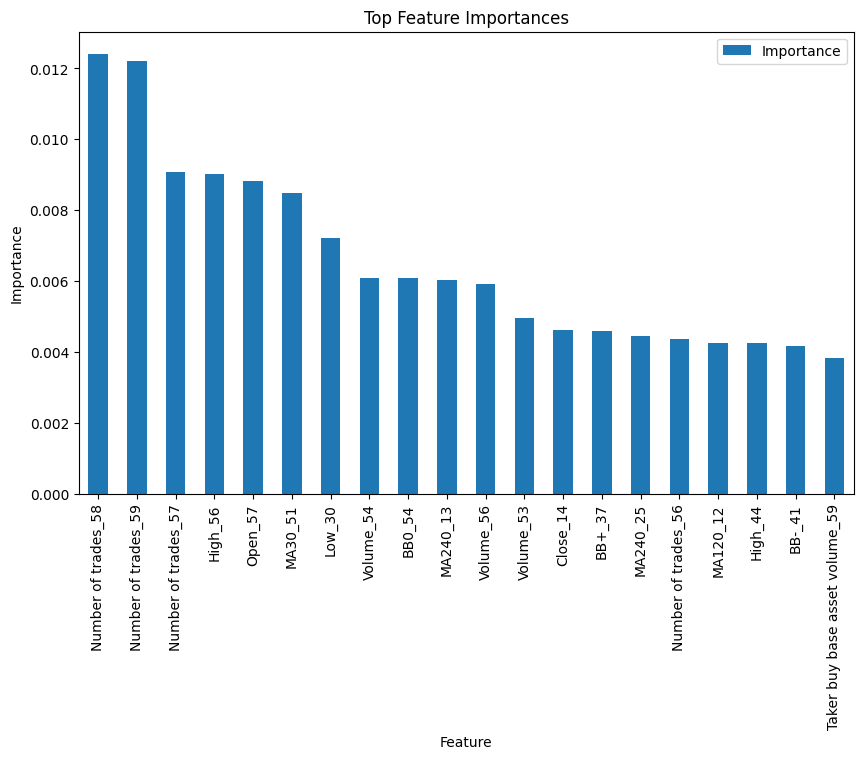

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_58    0.012415
            Number of trades_59    0.012205
            Number of trades_57    0.009080
                        High_56    0.009010
                        Open_57    0.008811
                        MA30_51    0.008492
                         Low_30    0.007199
                      Volume_54    0.006080
                         BB0_54    0.006074
                       MA240_13    0.006041
                      Volume_56    0.005900
                      Volume_53    0.004941
                       Close_14    0.004623
                         BB+_37    0.004587
                       MA240_25    0.004442
            Number of trades_56    0.004348
                       MA120_12    0.004262
                        High_44    0.004244
                         BB-_41    0.004173
 Taker buy base asset volume_59    0.003827
                       MA120_55    0.003795
    

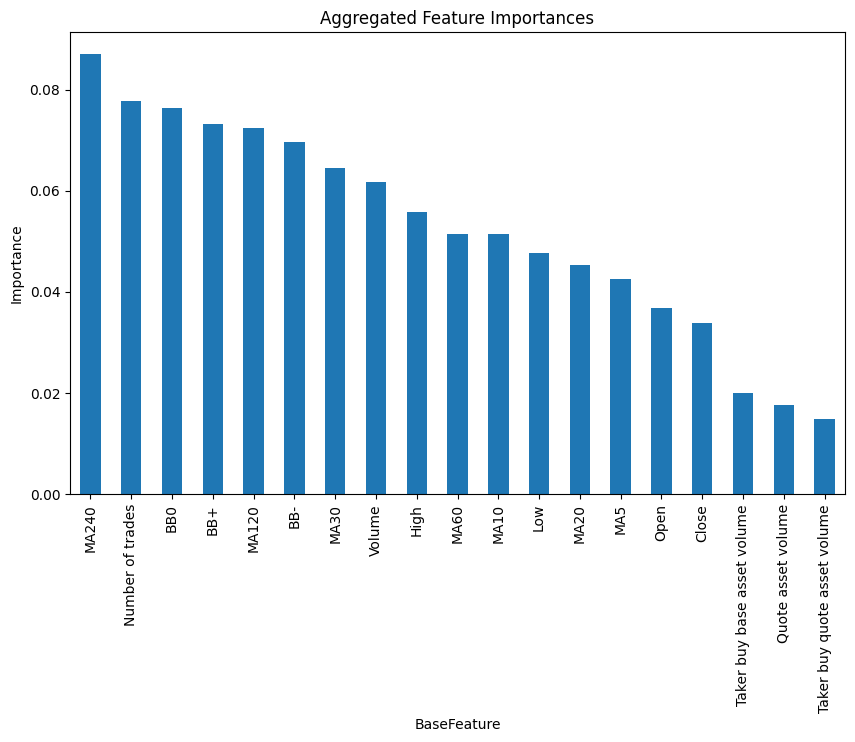

Sorted Aggregated Feature Importances:
BaseFeature
MA240                           0.086984
Number of trades                0.077746
BB0                             0.076373
BB+                             0.073176
MA120                           0.072315
BB-                             0.069648
MA30                            0.064549
Volume                          0.061632
High                            0.055854
MA60                            0.051481
MA10                            0.051395
Low                             0.047686
MA20                            0.045362
MA5                             0.042597
Open                            0.036909
Close                           0.033893
Taker buy base asset volume     0.019928
Quote asset volume              0.017588
Taker buy quote asset volume    0.014884
import 80 Data Done
import RFC model Done


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


prediction Done
[-1  0  1]
Accuracy: 0.7148692669642703
Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.68      0.69     19395
           0       0.70      0.85      0.77     20460
           1       0.74      0.60      0.66     18164

    accuracy                           0.71     58019
   macro avg       0.72      0.71      0.71     58019
weighted avg       0.72      0.71      0.71     58019



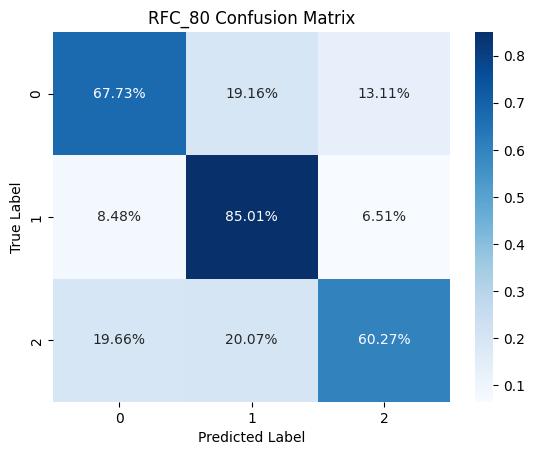

wrong count : 16543, correct count : 41476
accuracy? : 71.48692669642703
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


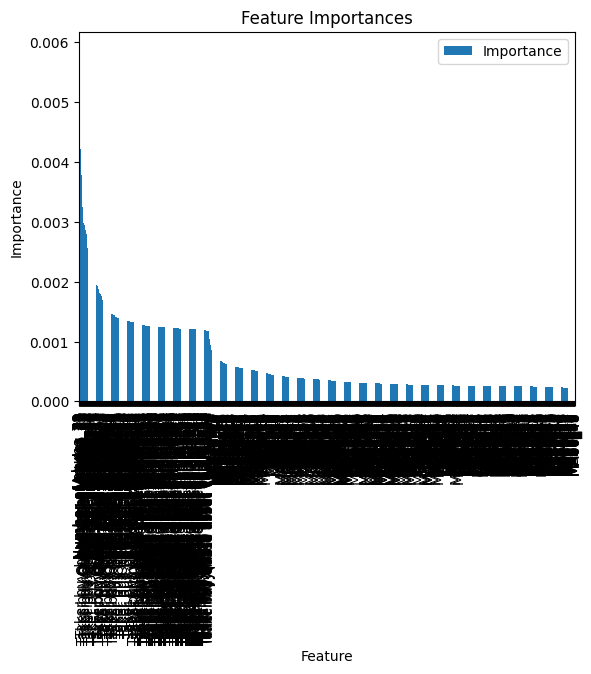

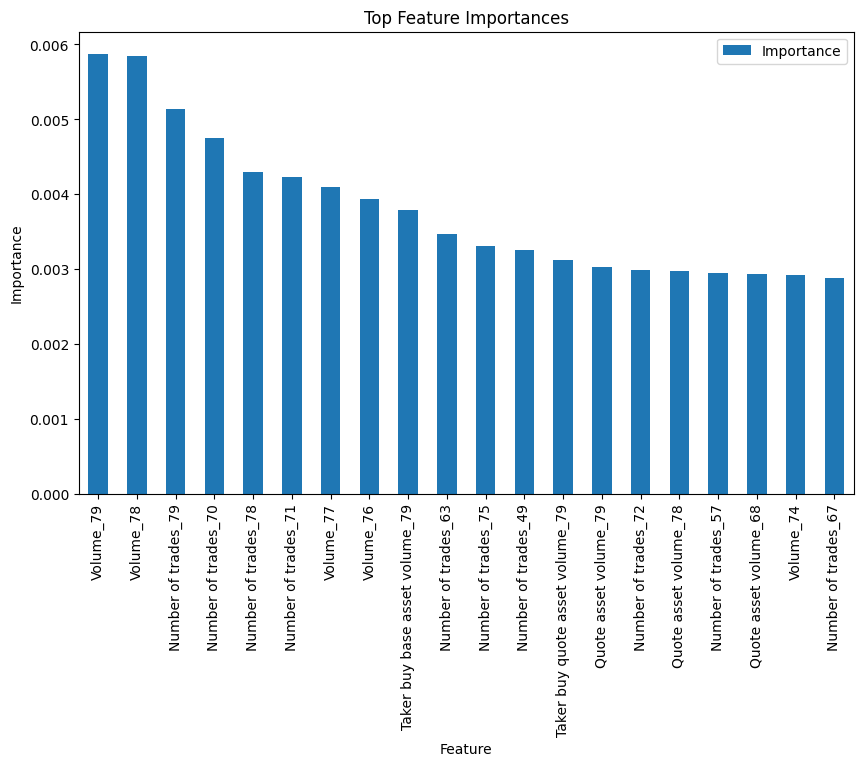

Sorted Feature Importances:
                        Feature  Importance
                      Volume_79    0.005878
                      Volume_78    0.005851
            Number of trades_79    0.005140
            Number of trades_70    0.004746
            Number of trades_78    0.004293
            Number of trades_71    0.004223
                      Volume_77    0.004094
                      Volume_76    0.003942
 Taker buy base asset volume_79    0.003788
            Number of trades_63    0.003462
            Number of trades_75    0.003314
            Number of trades_49    0.003255
Taker buy quote asset volume_79    0.003121
          Quote asset volume_79    0.003032
            Number of trades_72    0.002985
          Quote asset volume_78    0.002972
            Number of trades_57    0.002942
          Quote asset volume_68    0.002939
                      Volume_74    0.002926
            Number of trades_67    0.002880
 Taker buy base asset volume_78    0.002864
    

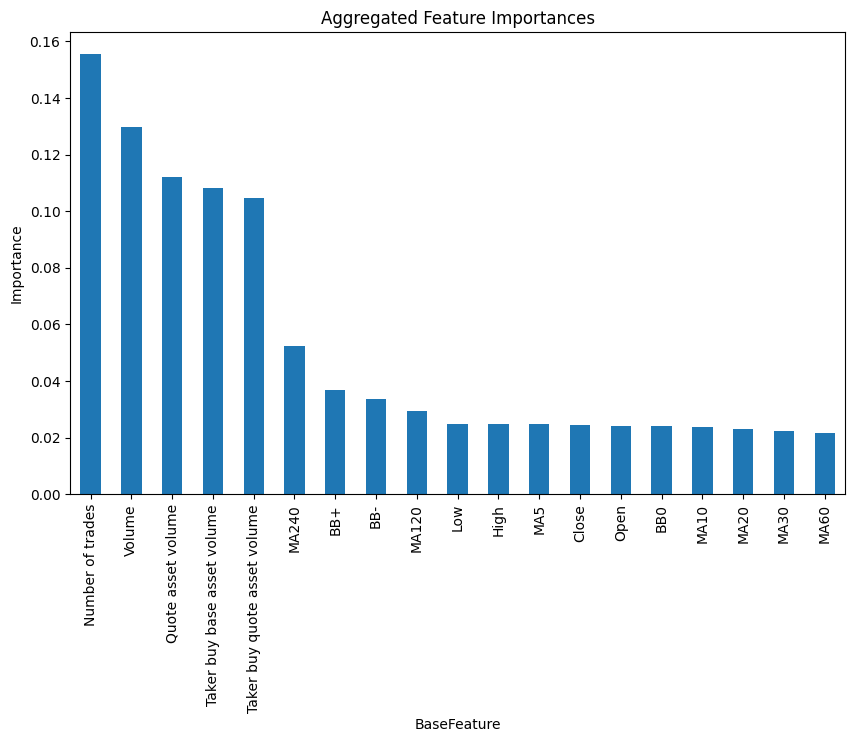

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.155444
Volume                          0.129690
Quote asset volume              0.112156
Taker buy base asset volume     0.108301
Taker buy quote asset volume    0.104769
MA240                           0.052212
BB+                             0.036726
BB-                             0.033620
MA120                           0.029474
Low                             0.024949
High                            0.024856
MA5                             0.024682
Close                           0.024485
Open                            0.023974
BB0                             0.023968
MA10                            0.023893
MA20                            0.022903
MA30                            0.022208
MA60                            0.021689
import 80 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5886002861131698
Classification Report:
              precision    recall  f1-score   suppor

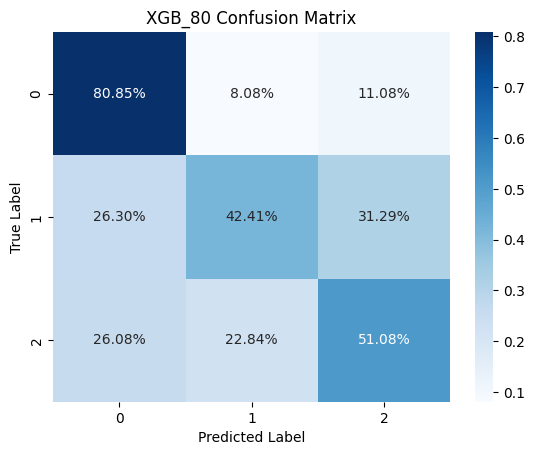

wrong count : 23869, correct count : 34150
accuracy? : 58.860028611316984
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


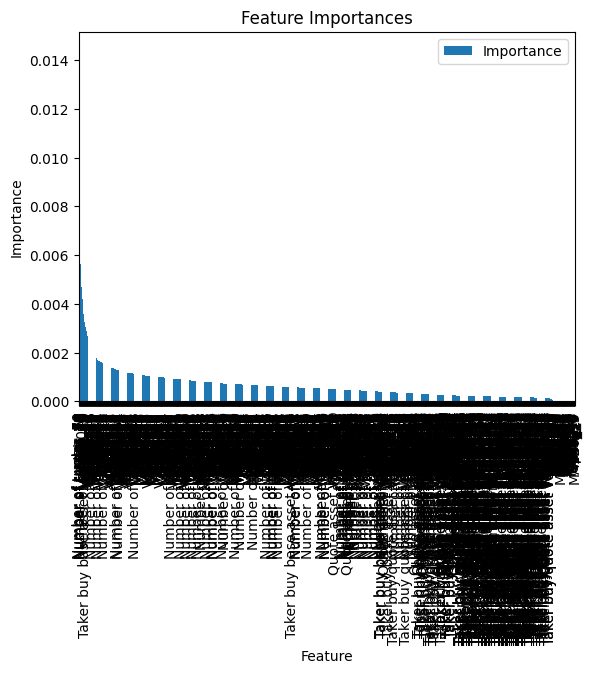

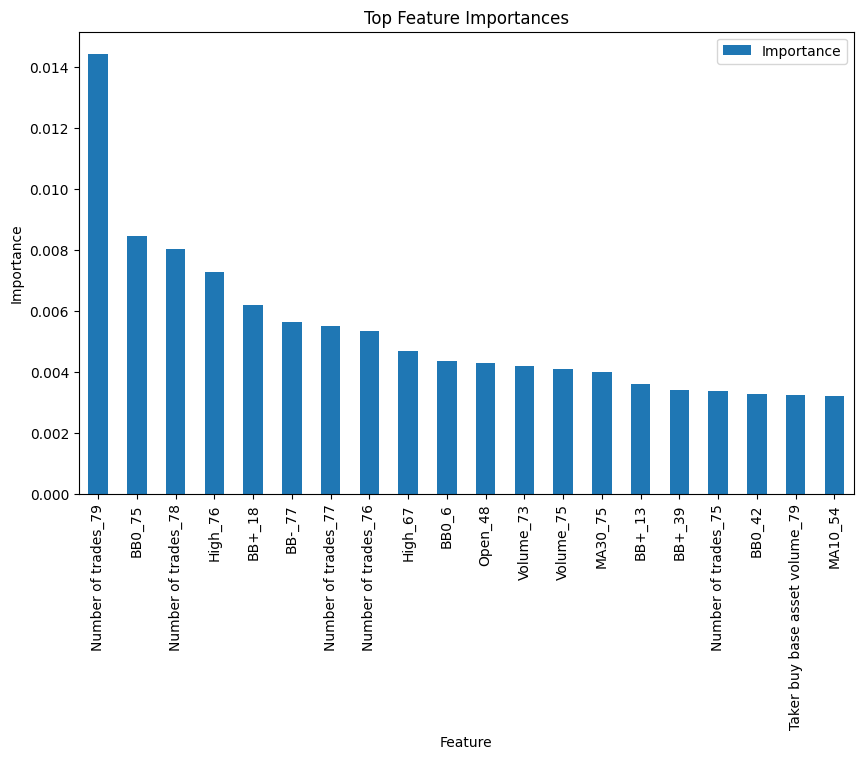

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_79    0.014434
                         BB0_75    0.008461
            Number of trades_78    0.008018
                        High_76    0.007258
                         BB+_18    0.006178
                         BB-_77    0.005643
            Number of trades_77    0.005485
            Number of trades_76    0.005318
                        High_67    0.004684
                          BB0_6    0.004338
                        Open_48    0.004273
                      Volume_73    0.004190
                      Volume_75    0.004090
                        MA30_75    0.003984
                         BB+_13    0.003605
                         BB+_39    0.003414
            Number of trades_75    0.003378
                         BB0_42    0.003276
 Taker buy base asset volume_79    0.003241
                        MA10_54    0.003207
                      Volume_64    0.003035
    

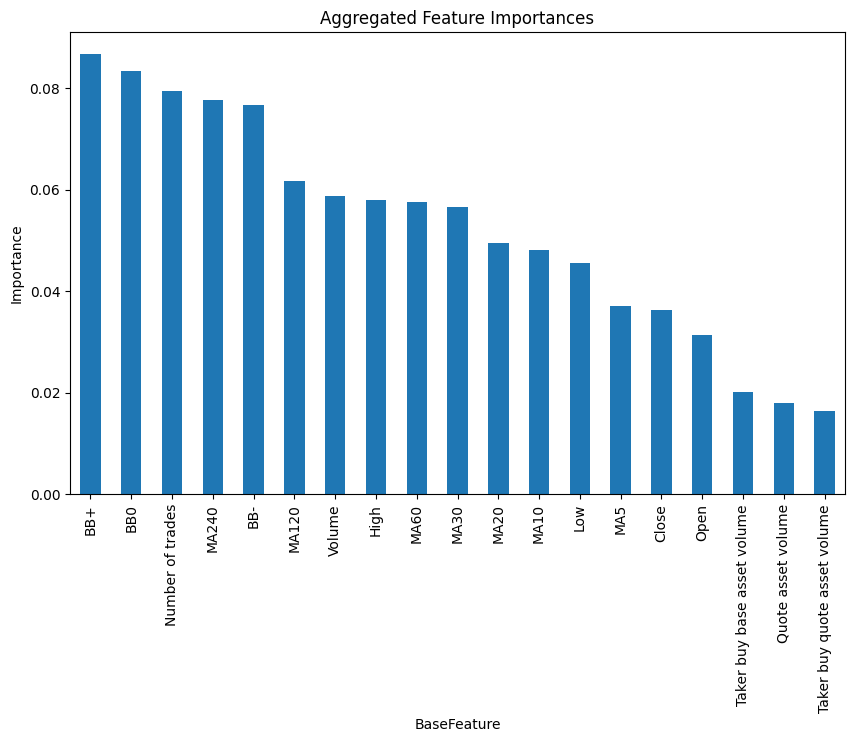

Sorted Aggregated Feature Importances:
BaseFeature
BB+                             0.086745
BB0                             0.083527
Number of trades                0.079474
MA240                           0.077741
BB-                             0.076758
MA120                           0.061829
Volume                          0.058881
High                            0.057944
MA60                            0.057599
MA30                            0.056721
MA20                            0.049556
MA10                            0.048177
Low                             0.045609
MA5                             0.037176
Close                           0.036350
Open                            0.031318
Taker buy base asset volume     0.020217
Quote asset volume              0.018037
Taker buy quote asset volume    0.016339


In [4]:
seq_lengths = [20,40,60,80]
models = [
    'RFC', 
    'XGB',
    ]

for seq_length in seq_lengths:
    for model_name in models:
        test_model(model_name, seq_length)